# Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EfficientDL/book/blob/main/codelabs/Chapter-10-Tensorflow/Quantization_with_TFLite.ipynb)

This is a toy colab to demonstrate different quantization options in TFLite to solve an image-classification problem with the [Flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers). You can explore it [here](https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=tf_flowers). We will be using a pre-trained MobileNet v2 model here. Note that the goal here is not to get the best performing model, but to demonstrate the quantization size, latency, and quality tradeoffs.

**Credit**: The following colab is based on the [original guide](https://www.tensorflow.org/lite/performance/post_training_quantization) with some changes that improve the model quality, simplify the flow a little bit, invoke the model and measure the latency, etc.

**Caveat**: Note that this notebook might get out-of-date as the support for quantized model training and inference gets better in Tensorflow, TFLite, other toolkits. There might be other alternatives as well that perform better than what we listed here.

# Train the baseline model.

Nothing fancy in this section, except the normalization part where you want to ensure that you keep it consistent with when you do model conversion and inference. This is required because you want the min and max in the floating point domain to match with the min and max in the quantized domain.

In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

## Setup the dataset to be used.

As mentioned above, we will be using th TF Flowers dataset that is hosted in [TFDS](https://www.tensorflow.org/datasets/catalog/tf_flowers).

In [2]:
# Size of the images for training and inference.
IMG_SIZE = 224

def ds_item_to_tuple(item):
  return (item['image'], item['label'])

def resize_image(image, label):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  # The normalization is important here, and you want to ensure that the min
  # and max of this normalized float32 range maps to min and max of the
  # quantized range later in the code.
  image = ((tf.cast(image, tf.float32)) / 255.)
  return image, label

(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    with_info=True,
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=False,
    read_config=tfds.ReadConfig(try_autocache=False)
)

train_ds = train_ds.map(ds_item_to_tuple).map(resize_image).cache()
val_ds = val_ds.map(ds_item_to_tuple).map(resize_image).cache()

train_ds_x, train_ds_y = tuple(zip(*list(train_ds.take(-1).as_numpy_iterator())))
train_ds_x = np.stack(train_ds_x)
train_ds_y = np.stack(train_ds_y)

val_ds_x, val_ds_y = tuple(zip(*list(val_ds.take(-1).as_numpy_iterator())))
val_ds_x = np.stack(val_ds_x)
val_ds_y = np.stack(val_ds_y)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


## Visualize the dataset.

Let's quickly take a look at some images and the respective classes to make sure everything is sane.

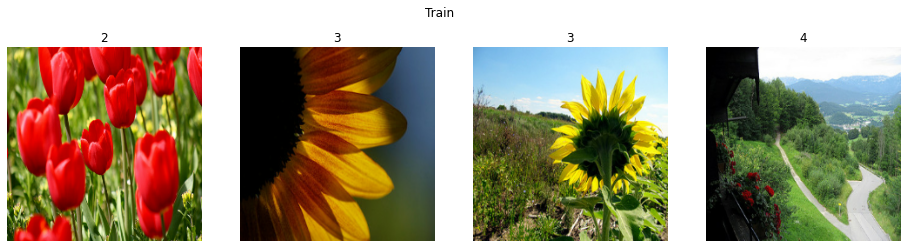

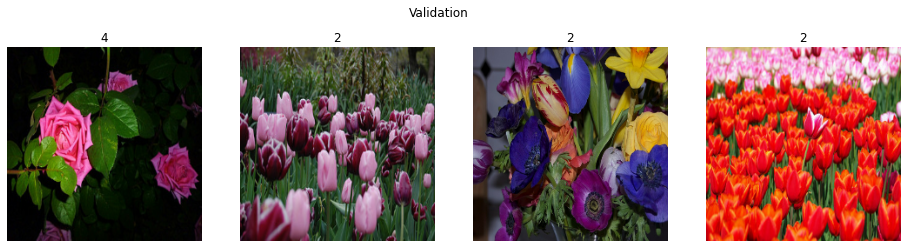

In [35]:
from matplotlib import pyplot as plt

def plot_dataset(ds, count=4, title='dataset'):
  size = 4
  cols = 4
  rows = int((count+cols-1) / cols)

  ds_itr = ds.as_numpy_iterator()
  fig = plt.figure(figsize=(size*cols, size*rows))
  items = map(lambda id: (id,) + ds_itr.next(), range(count))

  for id, image, label in items:
      colid = id % cols
      rowid = id / cols

      ax = fig.add_subplot(rows, cols, id+1)

      ax.set_title(label)
      ax.imshow(image)
      ax.axis("off")

  fig.suptitle(title)
  plt.show()

plot_dataset(train_ds, title='Train')
plot_dataset(val_ds, title='Validation')

## Actually train the model.

In [36]:
from tensorflow.keras import applications as apps
from tensorflow.keras import layers 
from tensorflow.keras import optimizers


DROPOUT_RATE = 0.3
LEARNING_RATE = 0.02
NUM_CLASSES = 5

def create_model():
  input = layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype=tf.float32)
  base_model = apps.mobilenet_v2.MobileNetV2(
      alpha=0.35,
      input_shape=(IMG_SIZE, IMG_SIZE, 3), 
      include_top=False
  )
  base_model.trainable = False
  x = base_model(input)

  x = layers.Flatten()(base_model.output)
  x = layers.Dropout(DROPOUT_RATE)(x)
  x = layers.Dense(32, activation='relu')(x)
  # x = layers.Dropout(DROPOUT_RATE)(x)
  output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return tf.keras.Model(base_model.input, output)


model = create_model()

INIT_LR = 1e-3
DECAY_RATE = 0.95
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=INIT_LR, 
      decay_steps=100,
      decay_rate=DECAY_RATE)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule), 
    loss='sparse_categorical_crossentropy', 
    metrics=['sparse_categorical_accuracy'])

batch_size = 32
batched_train_ds = train_ds.shuffle(
    5000, 
    reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
batched_val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = model.fit(
  batched_train_ds,
  validation_data=batched_val_ds,
  epochs=10,
)

Epoch 1/10
92/92 [==============================] - 46s 470ms/step - loss: 1.0838 - sparse_categorical_accuracy: 0.6945 - val_loss: 0.6291 - val_sparse_categorical_accuracy: 0.7834
Epoch 2/10
92/92 [==============================] - 39s 422ms/step - loss: 0.3738 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.5170 - val_sparse_categorical_accuracy: 0.8351
Epoch 3/10
92/92 [==============================] - 37s 402ms/step - loss: 0.2116 - sparse_categorical_accuracy: 0.9271 - val_loss: 0.6019 - val_sparse_categorical_accuracy: 0.8515
Epoch 4/10
92/92 [==============================] - 38s 418ms/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.6799 - val_sparse_categorical_accuracy: 0.8556
Epoch 5/10
92/92 [==============================] - 38s 410ms/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.5757 - val_sparse_categorical_accuracy: 0.8678
Epoch 6/10
92/92 [==============================] - 41s 449ms/step - loss: 0.0402 - sparse_cate

# Quantizing the models.

## TFLite Model Evaluation
Let's first define how we are going to evaluate the model. In the step below we mostly work around TFLite interpreter boilerplate. The interesting part is where we convert the model input from a float32 to int8, while ensuring that our (min, max) from the float32 domain matches with the (min, max) in the int8 domain.

In [46]:
def tflite_model_eval(
    model_content, test_images, test_labels, quantized, max_num_images=1000):
  """Evaluate the generated TFLite model."""
  # Load the TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_content=model_content)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  num_correct = 0
  num_total = 0

  for idx in range(min(len(test_images), max_num_images)):
    num_total = num_total + 1

    input_data = test_images[idx:idx+1]
    if quantized:
      # If the model is quantized, then we would have to provide the input 
      # in [-127,127]. Rescale the input data to be in [-127, 127] and then 
      # convert to int8.
      input_data = (((input_data - 0.5) * 2) * 127).astype(np.int8)

    # Set the input tensor and invoke the interpreter.
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    # The returned output is a tensor of logits, so we find the maximum in that 
    # tensor, and see if it matches the label.
    if np.argmax(output_data[0]) == test_labels[idx]:
      num_correct = num_correct + 1
  
  accuracy = num_correct * 1.0 / num_total
  print(f'Accuracy: {accuracy}')
  return accuracy

## TFLite Model Conversion.

There are a few different ways to convert a floating point model to a quantized one. The guide [here](https://www.tensorflow.org/lite/performance/post_training_quantization) lists a few different options, but we will go with the full integer quantization option, which not only gets us better latency due to the ops being in int8 (which are faster), but also gives us a better quality since we use our validation dataset as a 'reprsentative dataset' which is allows TFLite to calibrate and correct precision issues.

In [48]:
# Create the directory for storing TFLite models.
!mkdir -p 'tflite_models'

def convert_and_eval(
    model, quantized_export, test_dataset_x, test_dataset_y, 
    max_num_images=5000):
  """Helper method to convert the given model to TFLite and eval it."""
  # Set up the converter.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)

  if quantized_export:
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Set up the representative dataset that helps improve the quality
    # of the quantized model. 
    def representative_dataset():
      for idx in range(min(len(test_dataset_x), max_num_images)):
        yield [test_dataset_x[idx:idx+1]]

    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8

  tflite_model_str = converter.convert()

  model_type = ('quantized' if quantized_export else 'float')
  model_name = f'{model_type}.tflite'
  model_size_kbs = len(tflite_model_str) / 1024.
  print('Model Name: {}, Quantized: {}'.format(model_name, quantized_export))
  print(f'Model Size: {model_size_kbs:.2f} KB')
  with open(os.path.join('tflite_models', model_name), 'wb') as f:
    f.write(tflite_model_str)
  
  # Evaluate the model.
  model_accuracy = tflite_model_eval(
      tflite_model_str, test_dataset_x, test_dataset_y, quantized_export)
  return model_accuracy, model_size_kbs

## Convert and evaluate.
We can now convert and evaluate both floating-point and quantized models.

In [49]:
quant_accuracy, quant_size = convert_and_eval(model, True, val_ds_x, val_ds_y)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model Name: quantized.tflite, Quantized: True
Model Size: 2561.48 KB
Accuracy: 0.8719346049046321


In [50]:
float_accuracy, float_size = convert_and_eval(model, False, val_ds_x, val_ds_y)

Model Name: float.tflite, Quantized: False
Model Size: 9391.39 KB
Accuracy: 0.8719346049046321


## Size & quality comparison.

You should see a very similar model accuracy for both the models. The model size of the quantized model should be ~ 3.5 - 4x smaller. In some cases the quantized model might actually have a slightly better accuracy due to the regularizing effect of quantization.

In [54]:
size_comparison = float_size / quant_size
accuracy_delta = float_accuracy - quant_accuracy

print(f'The quantized model is {size_comparison:.2f}x smaller.')
print('The difference between the quantized and floating point model '
      f'accuracies is {accuracy_delta}% (absolute).')

The quantized model is 3.67x smaller.
The difference between the quantized and floating point model accuracies is 0.0% (absolute).


# Final latency benchmarking of the quantized model.
We will use pre-built binaries of the `benchmark_model` binaries that Tensorflow provides, however you can also build them from source for your platform. In the colab, you can run the binary directly, but most likely you would notice better latency gains on an ARM device such as an Android smartphone.

In general, we highly recommend going through the [README for the benchmark tool](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/tools/benchmark).

In [55]:
!wget -q https://storage.googleapis.com/tensorflow-nightly-public/prod/tensorflow/release/lite/tools/nightly/latest/linux_x86-64_benchmark_model
!chmod +x linux_x86-64_benchmark_model

In [56]:
!./linux_x86-64_benchmark_model --graph=tflite_models/float.tflite --use_xnnpack-true --warmup_runs=100 --num_runs=2000

STARTING!
Unconsumed cmdline flags: --use_xnnpack-true
Log parameter values verbosely: [0]
Min num runs: [2000]
Min warmup runs: [100]
Graph: [tflite_models/float.tflite]
Loaded model tflite_models/float.tflite
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
The input model file size (MB): 9.61679
Initialized session in 10.339ms.
Running benchmark for at least 100 iterations and at least 0.5 seconds but terminate if exceeding 150 seconds.
count=107 first=6315 curr=4297 min=4098 max=9991 avg=4628.88 std=791

Running benchmark for at least 2000 iterations and at least 1 seconds but terminate if exceeding 150 seconds.
count=2000 first=4324 curr=4754 min=3948 max=25727 avg=4874.64 std=1665

Inference timings in us: Init: 10339, First inference: 6315, Warmup (avg): 4628.88, Inference (avg): 4874.64
Note: as the benchmark tool itself affects memory footprint, the following is only APPROXIMATE to the actual memory footprint of the model at runtime. Take the information at your discret

In [57]:
!./linux_x86-64_benchmark_model --graph=tflite_models/quantized.tflite --use_xnnpack-true --warmup_runs=100 --num_runs=2000

STARTING!
Unconsumed cmdline flags: --use_xnnpack-true
Log parameter values verbosely: [0]
Min num runs: [2000]
Min warmup runs: [100]
Graph: [tflite_models/quantized.tflite]
Loaded model tflite_models/quantized.tflite
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
The input model file size (MB): 2.62295
Initialized session in 4.937ms.
Running benchmark for at least 100 iterations and at least 0.5 seconds but terminate if exceeding 150 seconds.
count=134 first=4626 curr=3410 min=3271 max=5717 avg=3718.54 std=636

Running benchmark for at least 2000 iterations and at least 1 seconds but terminate if exceeding 150 seconds.
count=2000 first=4051 curr=3348 min=3261 max=9593 avg=3780.71 std=731

Inference timings in us: Init: 4937, First inference: 4626, Warmup (avg): 3718.54, Inference (avg): 3780.71
Note: as the benchmark tool itself affects memory footprint, the following is only APPROXIMATE to the actual memory footprint of the model at runtime. Take the information at your dis

For the above two code snippets, we see the following latencies for float and quantized models. All numbers are in microseconds.

**Floating Point**
```
Inference timings in us: Init: 10339, First inference: 6315, Warmup (avg): 4628.88, Inference (avg): 4874.64
```

**Quantized**
```
Inference timings in us: Init: 4937, First inference: 4626, Warmup (avg): 3718.54, Inference (avg): 3780.71
```

Thus, **the latency speedup was 1.29x**. This is pretty good for not losing any model accuracy and also a 3.67x smaller model size.


## Benchmarking on an Android ARM device.
In the above section we benchmarked the models directly from the notebook on x86 and see a significant latency gain. We can actually get a latency gain on an ARM device too, since TFLite comes with quantized implementation of common operations which are optimized for ARM too.

You can run the following commands to benchmark the model on your device.

### Download the files on your machine.
In order to benchmark on your device, let's download the dense and sparse models first to your machine.

In [14]:
from google.colab import files

In [59]:
files.download('tflite_models/float.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
files.download('tflite_models/quantized.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download all the required binaries, and push them to the device.

For Android devices, we need the Android Debugger Bridge (ADB) that allows us to push binaries and files to it, and then run commands on it directly. You can go through the instructions [here](https://developer.android.com/studio/command-line/adb) to install ADB on your machine, if you don't have it already.

Once you have `adb` working on your machine, you need to download and push the right `benchmark_model` binary to the device. Note that you can build your own binary by downloading and cloning the tensorflow repository and then building the benchmark_model rule, or pick any other binary from [here](https://www.tensorflow.org/lite/performance/measurement#native_benchmark_binary).

```
wget https://storage.googleapis.com/tensorflow-nightly-public/prod/tensorflow/release/lite/tools/nightly/latest/android_aarch64_benchmark_model
```

```
adb push android_aarch64_benchmark_model /data/local/tmp/benchmark_model
```

Finally, push the models to the device as well.

```
adb push ~/Downloads/float.tflite /data/local/tmp/
```

```
adb push ~/Downloads/quantized.tflite /data/local/tmp/
```

### Run the benchmark.

We can now run the `benchmark_model` binary on the device and compare the results.

```
$ adb shell ./data/local/tmp/benchmark_model --graph=/data/local/tmp/float.tflite --warmup_runs=5 --num_runs=2000
STARTING!
Log parameter values verbosely: [0]
Min num runs: [2000]
Min warmup runs: [5]
Graph: [/data/local/tmp/float.tflite]
Loaded model /data/local/tmp/float.tflite
INFO: Initialized TensorFlow Lite runtime.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
VERBOSE: Replacing 70 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions for the whole graph.
The input model file size (MB): 9.61679
Initialized session in 86.527ms.
Running benchmark for at least 5 iterations and at least 0.5 seconds but terminate if exceeding 150 seconds.
count=33 first=33140 curr=14257 min=13957 max=33140 avg=15227 std=3457

Running benchmark for at least 2000 iterations and at least 1 seconds but terminate if exceeding 150 seconds.
count=2000 first=14380 curr=14034 min=13765 max=17836 avg=14367.6 std=713

Inference timings in us: Init: 86527, First inference: 33140, Warmup (avg): 15227, Inference (avg): 14367.6
Note: as the benchmark tool itself affects memory footprint, the following is only APPROXIMATE to the actual memory footprint of the model at runtime. Take the information at your discretion.
Memory footprint delta from the start of the tool (MB): init=19.8086 overall=25.3789
```

```
$ adb shell ./data/local/tmp/benchmark_model --graph=/data/local/tmp/quantized.tflite --warmup_runs=5 --num_runs=2000
STARTING!
Log parameter values verbosely: [0]
Min num runs: [2000]
Min warmup runs: [5]
Graph: [/data/local/tmp/quantized.tflite]
Loaded model /data/local/tmp/quantized.tflite
INFO: Initialized TensorFlow Lite runtime.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
VERBOSE: Replacing 69 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 2 partitions for the whole graph.
The input model file size (MB): 2.62295
Initialized session in 31.734ms.
Running benchmark for at least 5 iterations and at least 0.5 seconds but terminate if exceeding 150 seconds.
count=42 first=20007 curr=11916 min=11525 max=20007 avg=12046.9 std=1393

Running benchmark for at least 2000 iterations and at least 1 seconds but terminate if exceeding 150 seconds.
count=2000 first=12005 curr=11604 min=11412 max=20204 avg=11820.2 std=607

Inference timings in us: Init: 31734, First inference: 20007, Warmup (avg): 12046.9, Inference (avg): 11820.2
Note: as the benchmark tool itself affects memory footprint, the following is only APPROXIMATE to the actual memory footprint of the model at runtime. Take the information at your discretion.
Memory footprint delta from the start of the tool (MB): init=6.52344 overall=9.43359
```

In the above examples we saw that the floating point model took 14367.6 microseconds for inference v/s the quantized model which took 11820.2 microseconds. Thus the quantized model was **1.21x faster**

# Conclusion
As we see that getting full integer quantized models is easy with TFLite. In the above scenario, when comparing the two models (quantized and floating-point), the quantized model:
1. Had nearly the same accuracy.
1. Was **3.67x** smaller.
1. Was **1.29x** faster on x86.
1. Was **1.21x** faster on an Android ARM device.